In [1]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench301'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'cifar10'
data = dfs[dataset]

In [4]:
from naslib.search_spaces.nasbench301.conversions import convert_compact_to_genotype
from zc_combine.features.conversions import darts_to_graph


def get_darts_net(n):
    genotype = convert_compact_to_genotype(eval(n))
    return darts_to_graph(genotype.normal), darts_to_graph(genotype.reduce)

In [5]:
nets = {i: get_darts_net(data.loc[i]['net']) for i in data.index}

In [6]:
import json

with open('../zc_combine/configs/nb301_first.json', 'r') as f:
    cfg = json.load(f)

In [7]:
from zc_combine.features.darts import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [8]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

/tmp/ipykernel_2223/298988611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['val_accs'] = data['val_accs']


,op_count_normal_0,op_count_normal_1,op_count_normal_2,op_count_normal_3,op_count_normal_4,op_count_normal_5,op_count_normal_6,op_count_normal_7,op_count_reduce_0,op_count_reduce_1,...,"node_degree_allowed_[1, 2, 3]_normal_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_normal_out_degree","node_degree_allowed_[1, 2, 3]_normal_avg_in","node_degree_allowed_[1, 2, 3]_normal_avg_out","node_degree_allowed_[1, 2, 3]_reduce_c_{k-2}_degree","node_degree_allowed_[1, 2, 3]_reduce_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_reduce_out_degree","node_degree_allowed_[1, 2, 3]_reduce_avg_in","node_degree_allowed_[1, 2, 3]_reduce_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,4,1,0,2,0,2,1,2,4,0,...,0,0,0.428571,0.428571,2,0,0,0.428571,0.428571,93.459999
1,4,2,0,1,1,1,2,1,4,2,...,1,0,0.428571,0.428571,0,1,0,0.428571,0.428571,92.790001
2,4,4,0,1,1,1,0,1,4,1,...,2,0,0.714286,0.714286,0,3,0,0.571429,0.571429,93.320000
3,4,2,1,0,2,1,2,0,4,4,...,0,0,0.428571,0.428571,2,2,0,0.857143,0.857143,92.809998
4,4,1,2,1,1,1,1,1,4,1,...,0,0,0.571429,0.571429,2,1,0,0.714286,0.714286,92.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11216,4,1,0,0,0,0,4,3,4,0,...,1,0,0.142857,0.142857,0,1,0,0.285714,0.285714,92.919998
11217,4,0,1,0,1,4,0,2,4,1,...,0,0,0.142857,0.142857,2,0,0,0.428571,0.428571,92.750000
11218,4,3,0,0,0,2,2,1,4,2,...,1,0,0.428571,0.428571,2,0,0,0.714286,0.714286,92.080002


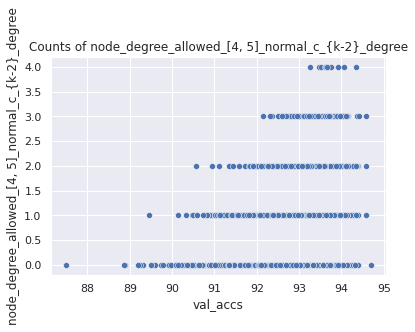

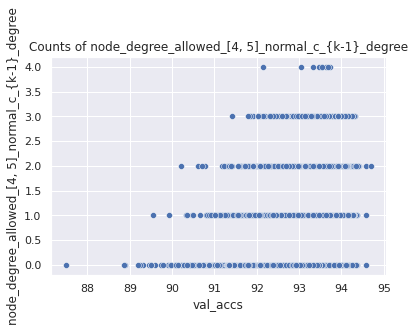

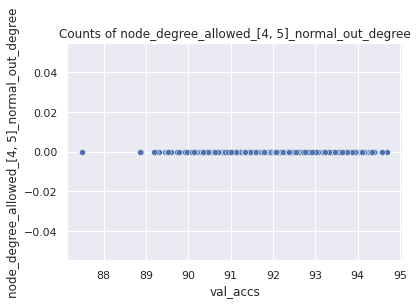

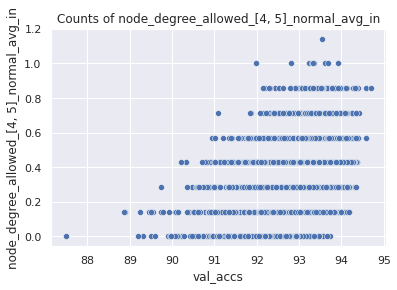

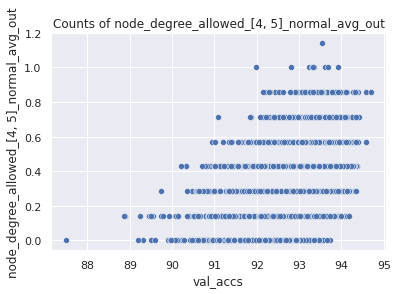

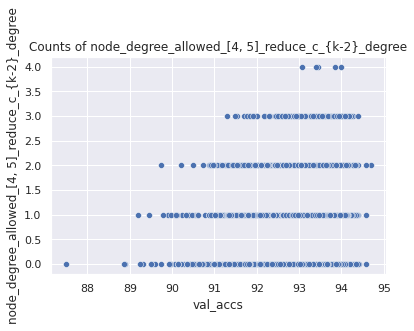

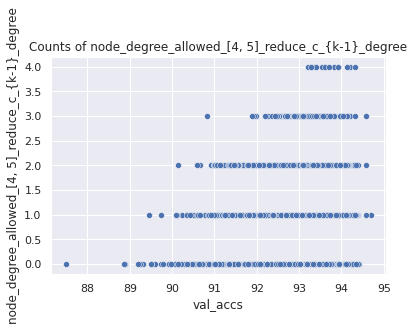

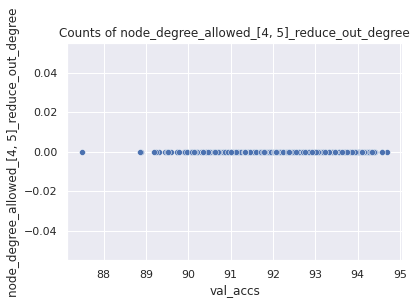

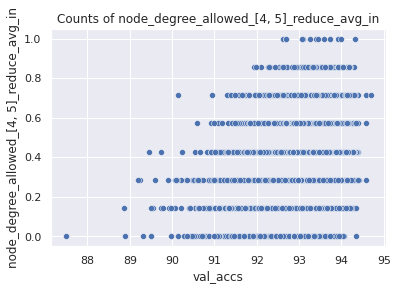

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['node_degree'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

max_plots = 8

for i, c in enumerate(plot_df.columns):
    if c == 'val_accs' or i > max_plots:
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [10]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(11221, 328)


,op_count_normal_0,op_count_normal_1,op_count_normal_2,op_count_normal_3,op_count_normal_4,op_count_normal_5,op_count_normal_6,op_count_normal_7,op_count_reduce_0,op_count_reduce_1,...,"node_degree_allowed_[1, 2, 3]_normal_out_degree","node_degree_allowed_[1, 2, 3]_normal_avg_in","node_degree_allowed_[1, 2, 3]_normal_avg_out","node_degree_allowed_[1, 2, 3]_reduce_c_{k-2}_degree","node_degree_allowed_[1, 2, 3]_reduce_c_{k-1}_degree","node_degree_allowed_[1, 2, 3]_reduce_out_degree","node_degree_allowed_[1, 2, 3]_reduce_avg_in","node_degree_allowed_[1, 2, 3]_reduce_avg_out",flops,params
0,4,1,0,2,0,2,1,2,4,0,...,0,0.428571,0.428571,2,0,0,0.428571,0.428571,169.285120,0.963882
1,4,2,0,1,1,1,2,1,4,2,...,0,0.428571,0.428571,0,1,0,0.428571,0.428571,166.336000,0.958442
2,4,4,0,1,1,1,0,1,4,1,...,0,0.714286,0.714286,0,3,0,0.571429,0.571429,145.413632,0.788522
3,4,2,1,0,2,1,2,0,4,4,...,0,0.428571,0.428571,2,2,0,0.857143,0.857143,157.939200,0.852778
4,4,1,2,1,1,1,1,1,4,1,...,0,0.571429,0.571429,2,1,0,0.714286,0.714286,152.385024,0.839978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11216,4,1,0,0,0,0,4,3,4,0,...,0,0.142857,0.142857,0,1,0,0.285714,0.285714,167.384576,0.980650
11217,4,0,1,0,1,4,0,2,4,1,...,0,0.142857,0.142857,2,0,0,0.428571,0.428571,209.344000,1.188458
11218,4,3,0,0,0,2,2,1,4,2,...,0,0.428571,0.428571,2,0,0,0.714286,0.714286,155.719168,0.827242
11219,4,1,1,1,0,1,1,3,4,0,...,0,0.428571,0.428571,1,2,0,0.714286,0.714286,150.967808,0.821162


In [12]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
#from naslib.predictors.trees.lgb import LGBoost


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, use_xgb=False, use_lgb=False, random_state=43, **kwargs):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        if not use_lgb:
            cls = XGBRegressorXGBRegressor if use_xgb else RandomForestRegressor
            rf = cls(random_state=random_state + i, **kwargs)
        else:
            rf = LGBoost()
        rf.fit(trx, tryy)

        if not use_lgb:
            res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [13]:
#from naslib.search_spaces.nasbench301.encodings import encode_adj

def encode_adj(arch):
    matrices = []
    ops = []
    NUM_VERTICES = 4
    true_num_vertices = NUM_VERTICES + 3
    for cell in arch:
        matrix = np.zeros((true_num_vertices, true_num_vertices))
        op_list = []
        for i, edge in enumerate(cell):
            dest = i // 2 + 2
            matrix[edge[0]][dest] = 1
            op_list.append(edge[1])
        for i in range(2, 6):
            matrix[i][-1] = 1
        matrices.append(matrix)
        ops.append(op_list)

    encoding = [*matrices[0].flatten(), *ops[0], *matrices[1].flatten(), *ops[1]]
    return np.array(encoding)

def to_adj_flat(d):
    res = {}
    for idx in d.index:
        comp = eval(d.loc[idx]['net'])
        res[idx] = encode_adj(comp)
    return res


def get_stacked_data(net_dict, idx):
    return np.vstack([net_dict[i] for i in idx])

In [14]:
import numpy as np

skip_dis = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    if skip_dis:
        break

    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

In [15]:
len(data)

11221

In [16]:
adj_nets = to_adj_flat(data)

In [17]:
ts = 1000
seed = 50
use_xgb = True
default_args = False

better_args = {} if not use_xgb or default_args else {
    #"early_stopping_rounds": 20,
    "tree_method": "hist",
    "subsample": 0.9,
    "n_estimators": 10000,
    "learning_rate": 0.01 #0.03 #0.1
}

all_proxies = False
prox_to_include = []
prox_to_include = ['nwot', 'fisher']
with_features = True

features = ['op_count', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
fd = fd[[c for c in fd.columns if 'avg' not in c]]
fd.columns = [str(c).replace('[', '(').replace(']', ')') for c in fd.columns]
#fd = fd[[c for c in fd.columns if c in topcols['feat'].to_numpy()]]
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5, use_xgb=use_xgb, **better_args)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.738943508949484, tau: 0.6849760717107083, corr: 0.8695107277665297


array([92.94056 , 92.683556, 93.284035, ..., 92.180336, 92.46289 ,
       92.656334], dtype=float32)

In [73]:
adj_train = get_stacked_data(adj_nets, train_X.index)
adj_test = get_stacked_data(adj_nets, test_X.index)

In [159]:
use_lgb = True

rfs, res = eval_rf(adj_train, adj_test, train_y, test_y, n_times=5, use_xgb=use_xgb, use_lgb=use_lgb, **better_args)
adj_rf_fitted = rfs[0]
print_means(res)

score: nan, tau: 0.584502422050531, corr: 0.7794962736237024


/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [97]:
compare_idx = 0
row_idx = test_X.iloc[compare_idx].name

assert (adj_test[compare_idx] == encode_adj(eval(data.loc[row_idx]['net']))).all()

Nick args size 1000 - score: 0.7350539849589437, tau: 0.6813921005392107, corr: 0.866695851168374

ags size 1000, only proxies: score: 0.2828648377522035, tau: 0.3703922655770016, corr: 0.5298845291575566

In [98]:
trainpreds = rf_fitted.predict(train_X)
testpreds = rf_fitted.predict(test_X)

In [99]:
import sklearn

va, nw = data['val_accs'], data['nwot']
kendalltau(va, nw)[0], spearmanr(va, nw)[0]

(0.3271026492340012, 0.4729313017917638)

In [173]:
subset_size = 200

use_adj = True
sample_data = adj_test if use_adj else test_X
sample_rf = adj_rf_fitted if use_adj else rf_fitted

idxs = np.random.randint(0, len(sample_data), subset_size)
smalltx, smallty = (sample_data[idxs] if isinstance(sample_data, np.ndarray) else sample_data.iloc[idxs]), test_y.iloc[idxs]

smallpred = sample_rf.predict(smalltx)
kendalltau(smallpred, smallty)[0], spearmanr(smallpred, smallty)[0]

(0.5984653989147337, 0.7936534370345162)

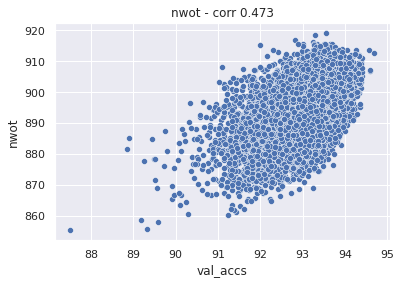

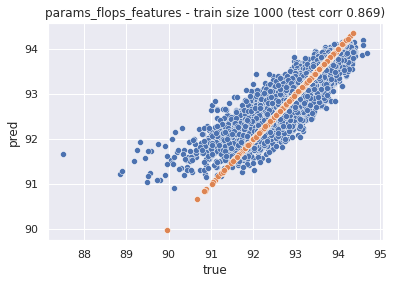

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

nwot_data = data[data.index.isin(test_X.index)]
nwot_corr = spearmanr(va, nw)[0]
sns.scatterplot(data=nwot_data, x='val_accs', y='nwot')
plt.title(f'nwot - corr {round(nwot_corr, 3)}')
plt.show()
sns.scatterplot(data=pd.DataFrame({'pred': testpreds, 'true': test_y}), x='true', y='pred')
#sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

corr = spearmanr(testpreds, test_y)[0]
plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(f"{plt_name} - train size {ts} (test corr {round(corr, 3)})")
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pcatx = pca.fit_transform(test_X)
print(pcatx.shape)

(10221, 3)


In [154]:
import plotly.express as px


pcadf = pd.DataFrame(pcatx)
pcadf['labels'] = labels
pcadf['val_accs'] = test_y.to_numpy()

fig = px.scatter_3d(
    pcadf, x=0, y=1, z=2, color=pcadf['val_accs']
)
fig.show()

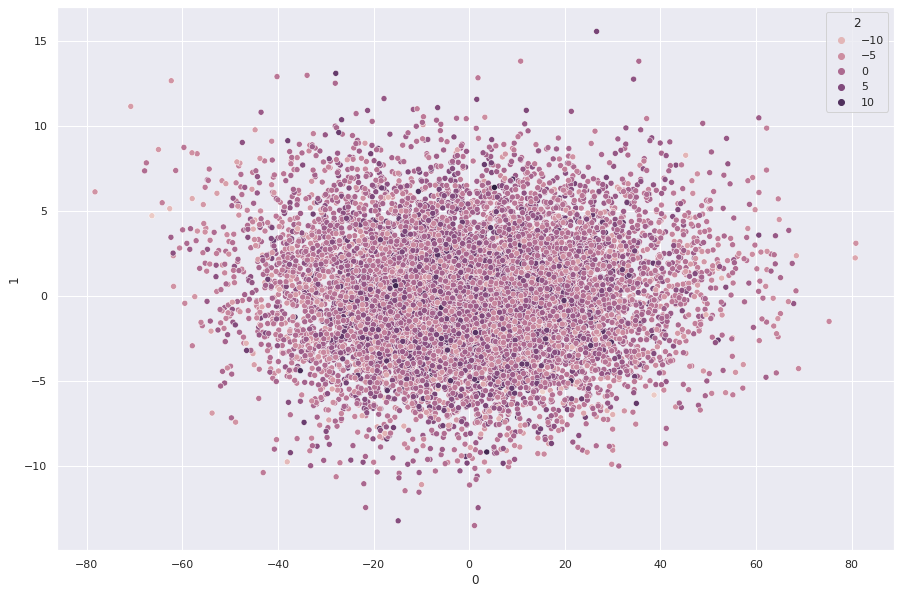

In [148]:
dbdf = pd.DataFrame(pcatx)
dbdf['labels'] = labels
#dbdf = dbdf[dbdf['labels'] > -1]
#dbdf = dbdf[dbdf['labels'] < 5]
plt.figure(figsize=(15, 10))
sns.scatterplot(data=dbdf, x=0, y=1, hue=2)#'labels')
plt.show()

In [215]:
imps = rf_fitted.feature_importances_

imps = pd.DataFrame({"importance": imps, "feat": fd.columns})
imps

,importance,feat
0,0.000000,op_count_normal_0
1,0.088804,op_count_normal_1
2,0.005052,op_count_normal_2
3,0.017821,op_count_normal_3
4,0.003882,op_count_normal_4
...,...,...
145,0.000000,"node_degree_allowed_[1, 2, 3]_reduce_out_degree"
146,0.098701,params
147,0.031688,flops
148,0.095803,nwot


In [167]:
topcols = imps.sort_values('importance', ascending=False)[:20]
topcols

,importance,feat
146,0.098701,params
148,0.095803,nwot
1,0.088804,op_count_normal_1
67,0.035761,"max_op_on_path_allowed_[1, 2, 3]_reduce_c_{k-1}"
147,0.031688,flops
149,0.027965,fisher
66,0.024331,"max_op_on_path_allowed_[1, 2, 3]_reduce_c_{k-2}"
61,0.024306,"max_op_on_path_allowed_[1, 2]_normal_c_{k-1}"
60,0.024133,"max_op_on_path_allowed_[1, 2]_normal_c_{k-2}"
128,0.022961,node_degree_allowed_[3]_normal_c_{k-2}_degree
